># Xception Increased Augmentation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip '/content/drive/MyDrive/Dataset/data.zip'

In [5]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

In [6]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/data'
SIZE = 224
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE,SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1)

Processing Images: 100%|██████████| 10379/10379 [00:21<00:00, 475.08it/s]


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [8]:
batch_size = 32
picture_size = (224, 224)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed = 22
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed = 22
)

Found 10379 files belonging to 38 classes.
Using 8304 files for training.
Found 10379 files belonging to 38 classes.
Using 2075 files for validation.


In [11]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomZoom, RandomBrightness, RandomContrast
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception

In [12]:
no_of_classes = 38

with stg.scope():
    img_augmentation = Sequential(
    [
        RandomRotation(factor=0.2),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.2),
        RandomFlip(mode="horizontal"),  # Horizontal flipping
        RandomContrast(0.2),  # Contrast adjustment
        RandomBrightness(0.2)  # Brightness adjustment
    ],
    name="img_augmentation"
    )

    base_model = Xception(weights="imagenet", input_shape=(SIZE, SIZE, 3), include_top=False)
    inputs = Input(shape=(SIZE, SIZE, 3))
    x = img_augmentation(inputs)
    outputs = base_model(x)

    x = GlobalAveragePooling2D()(outputs)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(no_of_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(
        loss='categorical_crossentropy',
        optimizer = Adam(learning_rate=0.001),
        metrics=['accuracy'])

model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                              

In [13]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=5,
                                verbose=1)

callbacks = [lr_scheduler, early_stopping]

In [14]:
import tensorflow as tf

model.trainable = True

history = model.fit(train_set, epochs=100, validation_data=validation_set, callbacks=callbacks,
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))

Epoch 1/100
260/260 [==============================] - 182s 536ms/step - loss: 3.5697 - accuracy: 0.0382 - val_loss: 4.8360 - val_accuracy: 0.0419 - lr: 0.0010
Epoch 2/100
260/260 [==============================] - 137s 527ms/step - loss: 2.9475 - accuracy: 0.1061 - val_loss: 3.7574 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 3/100
260/260 [==============================] - 137s 527ms/step - loss: 2.3481 - accuracy: 0.2134 - val_loss: 2.3795 - val_accuracy: 0.2304 - lr: 0.0010
Epoch 4/100
260/260 [==============================] - 137s 528ms/step - loss: 1.9265 - accuracy: 0.3318 - val_loss: 1.7165 - val_accuracy: 0.4043 - lr: 0.0010
Epoch 5/100
260/260 [==============================] - 137s 528ms/step - loss: 1.5568 - accuracy: 0.4613 - val_loss: 1.4534 - val_accuracy: 0.4896 - lr: 0.0010
Epoch 6/100
260/260 [==============================] - 137s 527ms/step - loss: 1.2454 - accuracy: 0.5759 - val_loss: 0.9804 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 7/100
260/260 [===================

In [15]:
test_data_dir = "/content/data"
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_loss, test_acc = model.evaluate_generator(test_generator)
print('Test accuracy:', test_acc)

Found 10379 images belonging to 38 classes.
Test accuracy: 0.9788997173309326


325/325 [==============================] - 42s 127ms/step
Accuracy: 0.9788997013199731


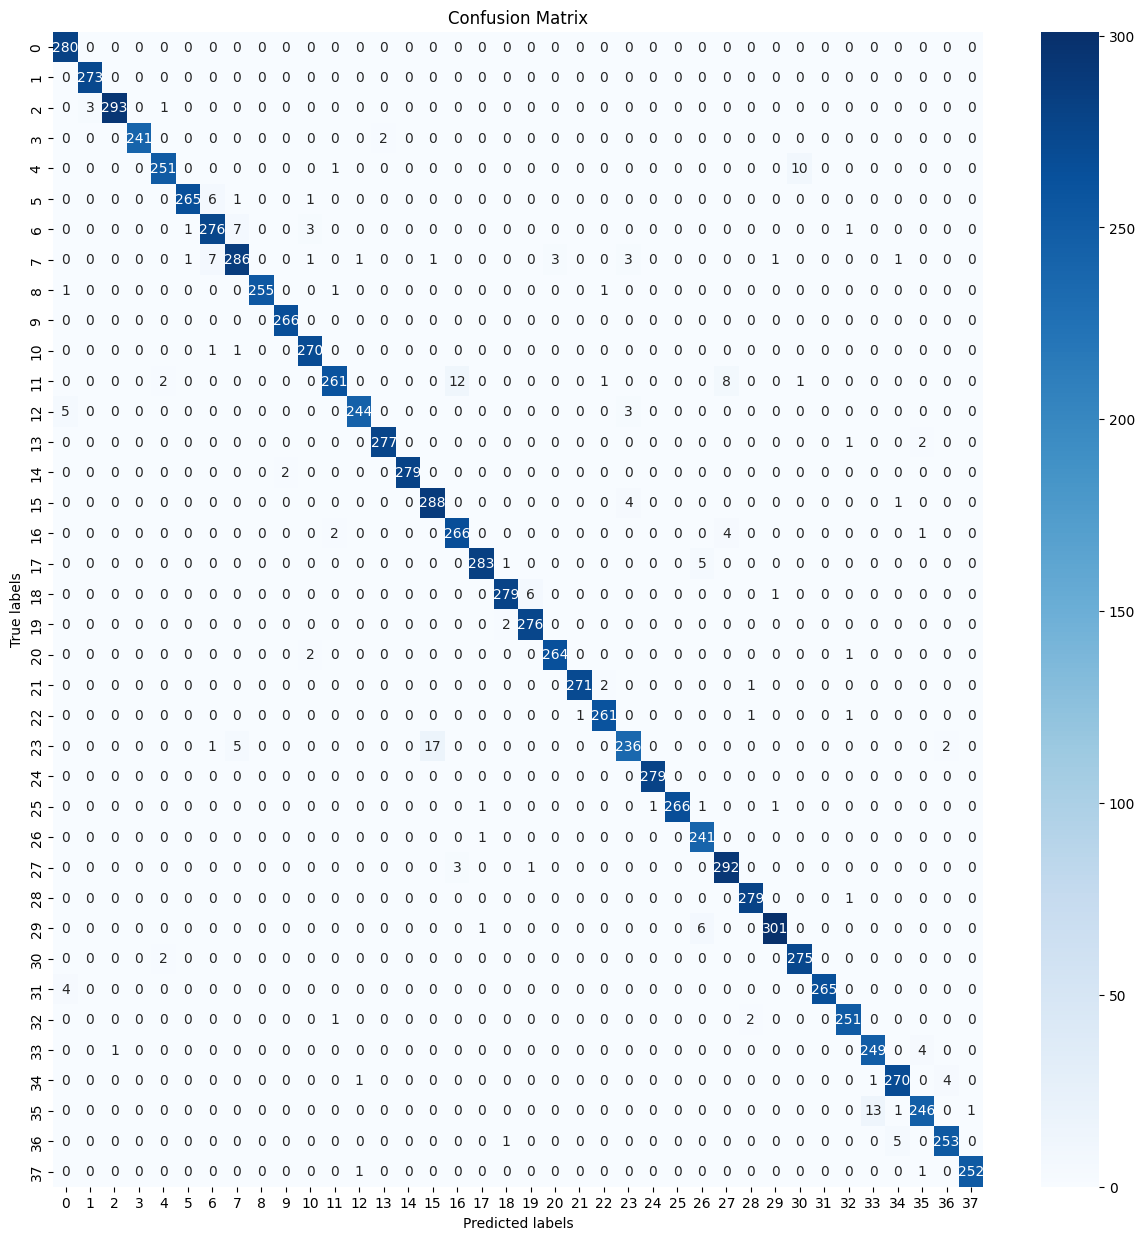

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       280
           1       0.99      1.00      0.99       273
           2       1.00      0.99      0.99       297
           3       1.00      0.99      1.00       243
           4       0.98      0.96      0.97       262
           5       0.99      0.97      0.98       273
           6       0.95      0.96      0.95       288
           7       0.95      0.94      0.95       305
           8       1.00      0.99      0.99       258
           9       0.99      1.00      1.00       266
          10       0.97      0.99      0.98       272
          11       0.98      0.92      0.95       285
          12       0.99      0.97      0.98       252
          13       0.99      0.99      0.99       280
          14       1.00      0.99      1.00       281
          15       0.94      0.98      0.96       293
          16       0.95      0.97      0.96       273
    

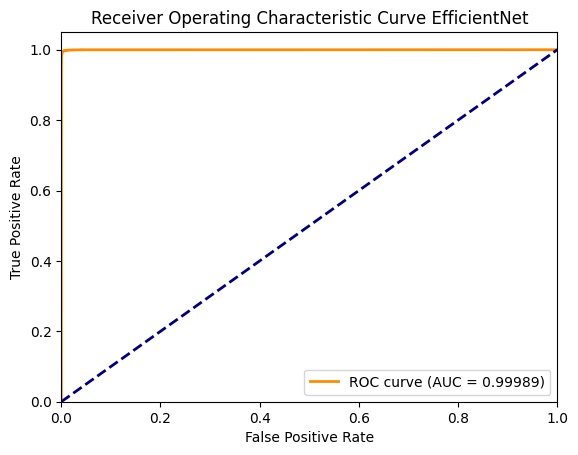

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate overall ROC AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve EfficientNet')
plt.legend(loc="lower right")
plt.show()